# <span style="color:#8B4513;"> Analysis of PPMI -omics datasets by Machine Learning
</span>



[<span style="color:#8B4513;"> **Zainab Nazari**</span>](mailto:z.nazari@ebri.com)
 
 <span style="color:#2B4913;">EBRI – European Brain Research Institute Rita Levi-Montalcini | MHPC - Master in High Performance Computing</span>

## Goal
By employing machine learning in PPMI clinical data set, we can develop predictive models that aid in the early diagnosis of the disease. These models can potentially identify specific genetic markers or gene signatures that correlate with disease progression or response to treatment.



In [ ]:
folder_path = '/home/znazari/data'  # Replace with the actual path to the folder
gif_filename = 'Substantia_nigra.gif'  # Replace with the actual filename

# Combine the folder path and filename
gif_path = f'{folder_path}/{gif_filename}'

# Display the gif

## Discussion
- [Parkinson's Disease](#matrixcreation)
- [PPMI Dataset](#preprocessing)
- [Motor Score](#results)
- [Proteomic CSF data](#preprocessing2)
- [Transcriptomic Data](#training)
- [Brain Image](#results)
- [Headaches](#results)


# Proteomic CSF Data 

- CSF is a clear, colorless fluid that surrounds the brain and spinal cord. It plays a crucial role in protecting and nourishing the central nervous system. Analyzing CSF can provide valuable insights into the biochemical changes associated with neurodegenerative diseases like Parkinson's

- proteomic analysis of CSF involves identifying and quantifying the proteins present in the fluid. This can provide information about the molecular signatures associated with Parkinson's disease.


In [27]:
%%capture
import matplotlib.pyplot as plt

# Data
labels = ['<50 years old', '50-59 years old', '60+ years old']
sizes = [10, 10, 80]  # Assuming percentages for illustration purposes
colors = ['lightcoral', 'lightskyblue', 'lightgreen']
explode = (0.1, 0, 0)  # Explode the 1st slice to highlight <50 years old

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Distribution of Parkinson\'s Disease Cases Based on Age')
plt.savefig('cases.png')


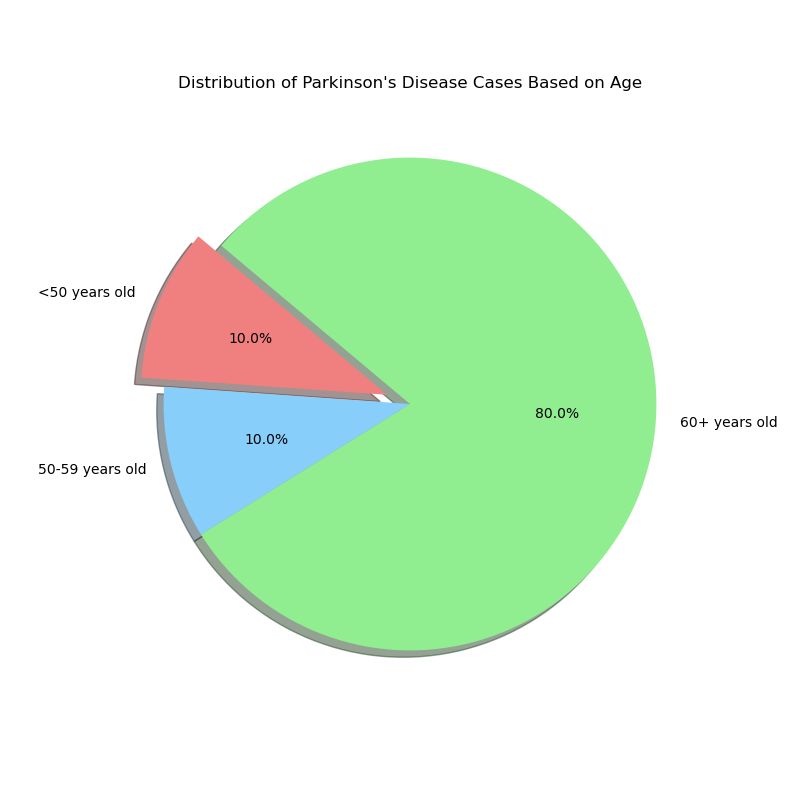

In [28]:
Image(filename='cases.png')

**Parkinson's disease** is a condition characterized by the gradual deterioration of the nervous system, primarily impacting a person's ability to move as well as mental disabilities.
- Approximately 10 million worldwide have Parkinson's, less than 1% of the total population. Most cases occur after 60, but 1 in 10 are under 50. Men are slightly more affected.
- Parkinson's disease is characterized by the degeneration and loss of dopamine-producing cells in a region of the brain called the substantia nigra. Dopamine is a neurotransmitter involved in the regulation of movement and other functions.

- The exact cause of Parkinson's disease is unknown, but a combination of genetic and environmental factors is believed to play a role.

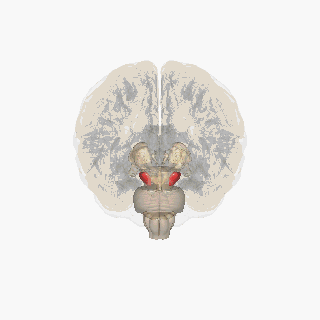

In [57]:
display(Image(filename=gif_path))

## Parkinson's Disease

<img src="parkinson_illustration.png" alt="Image Alt Text" width="800" height="100"/>



In [1]:
# In case you do not have following packages installed, uncomment instalisation.

#!pip install dask[complete];
# you need to run these in case dask gives you error, it might need update.
#!pip install --upgrade pandas "dask[complete]"
#python -m pip install "dask[dataframe]" --upgrade
import dask.dataframe as dd
import pandas as pd
import numpy as np
import os
import glob
import functools
from pathlib import Path
import matplotlib.pyplot as plt
#import rpy2 

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler



from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.inspection import permutation_importance 
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import SelectFromModel
from sklearn.utils import class_weight

from sklearn.impute import SimpleImputer

#!pip3 install xgboost
from xgboost import XGBClassifier

#!pip install conorm
import conorm # for tmm normalisation

#!pip3 install pydeseq2 or pip install pydeseq2
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data


from IPython.display import display, Image

#to install R :
#conda install -c r r-irkernel

#to install a library from R
#!pip install library edgeR


In [2]:
# Note that the counts file in the IR3 is around 152 G, and the files are located in scratch area.
path_to_files="/scratch/znazari/PPMI_ver_sep2022/RNA_Seq_data/star_ir3/counts/"
path1=Path("/scratch/znazari/PPMI_ver_sep2022/RNA_Seq_data/star_ir3/counts/")
path2 = Path("/home/znazari/data") # where the output data will be saved at the end.
path3=Path("/scratch/znazari/PPMI_ver_sep2022/study_data/Subject_Characteristics/")


In [3]:
visit = pd.read_csv(path2/"visit-data.csv")
visit

,Visit Code,Month,PD,Prodromal,Healthy controls
0,BL,0,851,557,230
1,V02,6,601,444,194
2,V04,12,615,444,185
3,V05,18,606,366,178
4,V06,24,579,424,174
5,V07,30,526,270,165
6,V08,36,554,378,167
7,V09,42,467,170,166
8,V10,48,501,291,162
9,V11,54,394,76,156


In [15]:
print(visit.columns)

Index(['Visit Code', 'Month ', 'PD', 'Prodromal', 'Healthy controls'], dtype='object')


In [24]:
%%capture
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# Assuming you have a DataFrame named "visit" with the specified columns
# Replace the path with the actual path to your data file


# Define the width of the bars
bar_width = 0.25

# Set the positions for the bars
r1 = np.arange(len(visit['Month ']))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create a color palette with warmer colors for PD patients
#colors = sns.color_palette("YlOrRd", n_colors=3)
# Define colors (warmer color for PD)
colors = ['#FF7F50', '#83CEEB', '#34FC50']  # Coral for PD, SkyBlue for Prodromal, and PaleGreen for Healthy Controls

# Plotting the bars with specified colors
plt.figure(figsize=(12, 8))
plt.bar(r1, visit['PD'], width=bar_width, edgecolor='white', label='Parkinson\'s Disease', alpha=0.7, color=colors[0])
plt.bar(r2, visit['Prodromal'], width=bar_width, edgecolor='white', label='Prodromal', alpha=0.7, color=colors[1])
plt.bar(r3, visit['Healthy controls'], width=bar_width, edgecolor='white', label='Healthy Controls', alpha=0.7, color=colors[2])

# Adding labels and title
plt.xlabel('Months After Visit', fontweight='bold')
plt.ylabel('Number of Subjects', fontweight='bold')
plt.title('Distribution of Subjects Over Time in PPMI Data', fontweight='bold')

# Adding xticks
plt.xticks([r + bar_width for r in range(len(visit['Month ']))], visit['Month '])

# Adding legend
plt.legend()

# Displaying the plot
plt.savefig('time_subjects.png')


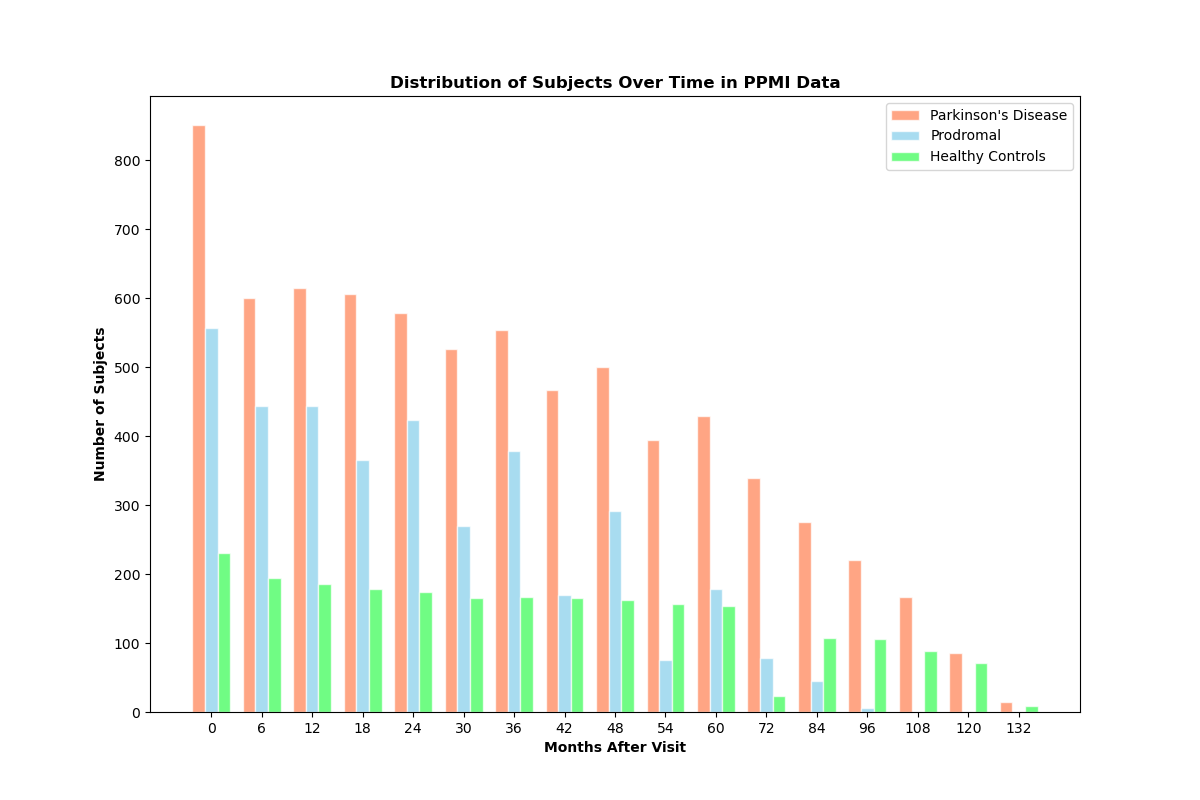

In [25]:
Image(filename='time_subjects.png')

In [5]:
# reading the file
read_ir3_counts = pd.read_csv(path2/"matrix_ir3_counts_bl.csv")
# setting the geneid as indexing column
read_ir3_counts.set_index('Geneid', inplace=True)
# result with removing the after dot (.) value, i.e. the version of the geneIDs is removed.
read_ir3_counts.index =read_ir3_counts.index.str.split('.').str[0]


#here we delete the duplicated gene IDs, first we find them then remove them from the gene IDs
# as they are duplicated and also they are very lowly expressed either zero or one in rare caes.

# Check for duplicate index values
is_duplicate = read_ir3_counts.index.duplicated()

# Display the duplicate index values
duplicate_indices = read_ir3_counts.index[is_duplicate]


# drop them (duplicated indices and their copies are deleted, 45 duplicatd indices and 90 are dropped)
to_be_deleted = list(duplicate_indices)
read_ir3_counts = read_ir3_counts.drop(to_be_deleted)

# we read the file where we have an intersection of geneIDs in IR3, counts, quant
intersect = pd.read_csv(path2/"intersect_IR3_ENG_IDs_LincRNA_ProtCoding_counts_quant_gene_transcript_only_tot_intsersect.txt")
intersection = read_ir3_counts.index.intersection(intersect['[IR3_gene_counts] and [IR3_quant_gene] and [IR3_quant_trans] and [lncRNA+ProtCod]: '])
filtered_read_ir3_counts = read_ir3_counts.loc[intersection]

# reading the file which contains diagnosis
diago=pd.read_csv(path3/"Participant_Status.csv", header=None )
diago1=diago.rename(columns=diago.iloc[0]).drop(diago.index[0]).reset_index(drop=True)

In [12]:
%%capture
import pandas as pd
import matplotlib.pyplot as plt


# Group by 'COHORT_DEFINITION' and count occurrences
diagnosis_counts = diago1['COHORT_DEFINITION'].value_counts()

# Set a professional color palette for both pie and bar charts
colors = plt.cm.Paired(range(len(diagnosis_counts)))

# Plotting the pie chart
plt.figure(figsize=(12, 6))
plt.subplot(1, 1, 1)  # Creating a subplot for the pie chart
patches, texts, autotexts = plt.pie(
    diagnosis_counts, labels=diagnosis_counts.index, autopct='%1.1f%%', startangle=140, colors=colors,
    wedgeprops=dict(width=0.3, edgecolor='w')  # Add a white border to pie chart wedges
)

# Adding a legend with associated colors
plt.legend(patches, diagnosis_counts.index, title='Diagnoses', loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

plt.title('Distribution of Patient Diagnoses')
plt.tight_layout()  # Ensures that the plots do not overlap
plt.savefig('distribution_patients.png');


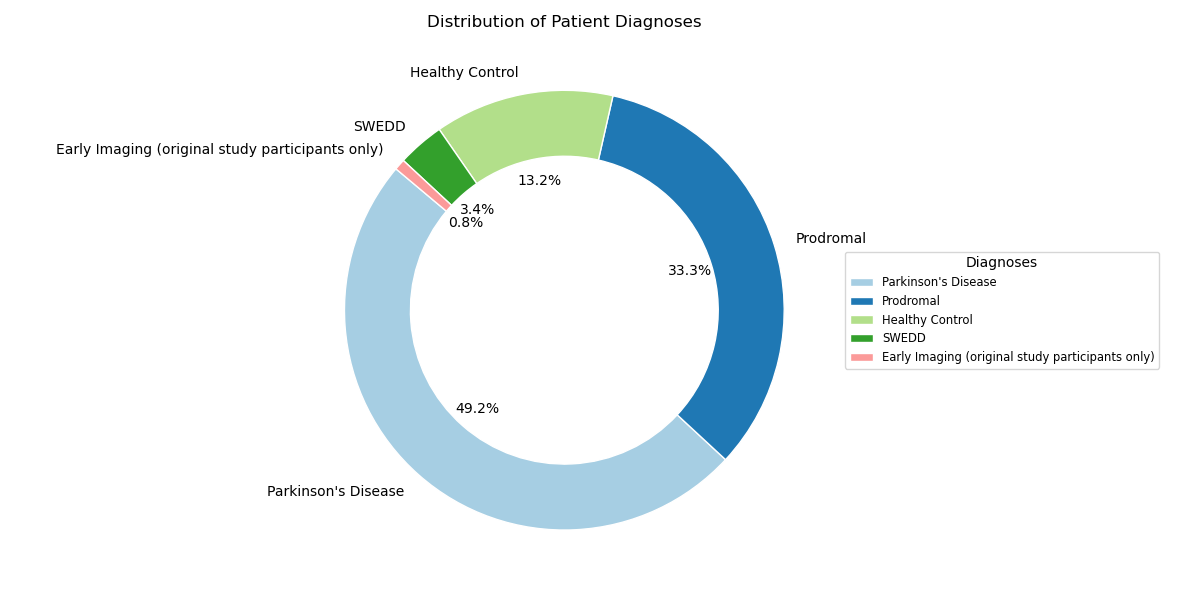

In [10]:
Image(filename='distribution_patients.png')

In [13]:
%%capture
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame
# diago1 = pd.DataFrame(
#     'PATNO': [1, 2, 3, 4, 5],
#     'COHORT_DEFINITION': ['Type A', 'Type B', 'Type A', 'Type C', 'Type B']
# })

# Filter DataFrame to include only 'Healthy control' and 'Parkinson's Disease'
filtered_diagnosis = diago1[diago1['COHORT_DEFINITION'].isin(['Healthy Control', "Parkinson's Disease"])]

# Group by 'COHORT_DEFINITION' and count occurrences
diagnosis_counts = filtered_diagnosis['COHORT_DEFINITION'].value_counts()

# Set a professional color palette for both pie and bar charts
colors = plt.cm.Paired(range(len(diagnosis_counts)))

# Plotting the pie chart
plt.figure(figsize=(12, 6))

# Pie Chart
plt.subplot(1, 2, 1)  # Creating a subplot for the pie chart
patches, texts, autotexts = plt.pie(
    diagnosis_counts, labels=diagnosis_counts.index, autopct='%1.1f%%', startangle=140, colors=colors,
    wedgeprops=dict(width=0.3, edgecolor='w')  # Add a white border to pie chart wedges
)

# Adding a legend with associated colors
plt.legend(patches, diagnosis_counts.index, title='Diagnoses', loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

plt.title('Pie Chart: Distribution of Patient Diagnoses')

# Bar Chart
plt.subplot(1, 2, 2)  # Creating a subplot for the bar chart
plt.bar(diagnosis_counts.index, diagnosis_counts, color=colors)

plt.title('Bar Chart: Distribution of Patient Diagnoses')

plt.tight_layout()  # Ensures that the plots do not overlap
#plt.show()
plt.savefig('my_plot.png')


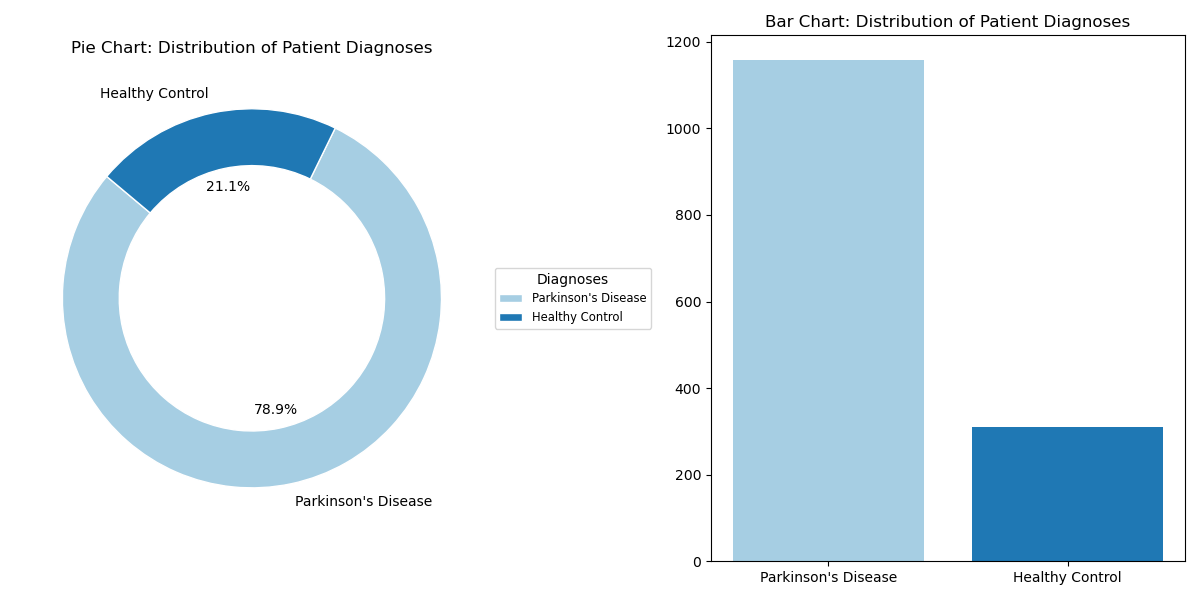

In [20]:

Image(filename='my_plot.png')

In [30]:
imaging = pd.read_csv(path2/"DaTScan_Analysis_only_SC.txt",delimiter='\t')

In [32]:
columns_to_remove=['PROTOCOL', 'EVENT_ID','DATSCAN_LIGAND','DATSCAN_DATE','DATSCAN_ANALYZED']
imaging_=imaging.drop(columns=columns_to_remove)

In [33]:
%%capture
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming "imaging_" is your DataFrame

# Set the style for seaborn plots
sns.set(style="whitegrid")

# Example 1: Boxplot to compare distribution of brain parts for different diagnoses
#plt.figure(figsize=(12, 8))
#sns.boxplot(x="Diagnosis", y="DATSCAN_CAUDATE_R", data=imaging_)
#plt.title('Distribution of DATSCAN_CAUDATE_R across Diagnoses')
#plt.show()

# Example 2: Pairplot for pairwise relationships between brain parts
sns.pairplot(imaging_[["DATSCAN_CAUDATE_R", "DATSCAN_CAUDATE_L", "DATSCAN_PUTAMEN_R", "DATSCAN_PUTAMEN_L", "DATSCAN_PUTAMEN_R_ANT", "DATSCAN_PUTAMEN_L_ANT", "Diagnosis"]],
             hue="Diagnosis", diag_kind='kde')
plt.suptitle('Pairwise Relationships and Distributions of Brain Parts by Diagnosis', y=1.02)


# Specify the filename for saving
filename = 'pairwise.png'

# Set the width and height for saving (in inches)
width_inches = 4  # Adjust according to your preference
height_inches = 3  # Adjust according to your preference

# Set the dots per inch (dpi) for the saved image
dpi = 100  # Adjust according to your preference

# Save the plot with the specified size and resolution
plt.savefig(filename, dpi=dpi, bbox_inches='tight', pad_inches=0.1, figsize=(width_inches, height_inches))


# Example 3: Correlation heatmap for brain parts
#corr_matrix = imaging_[["DATSCAN_CAUDATE_R", "DATSCAN_CAUDATE_L", "DATSCAN_PUTAMEN_R", "DATSCAN_PUTAMEN_L", "DATSCAN_PUTAMEN_R_ANT", "DATSCAN_PUTAMEN_L_ANT"]].corr()
#plt.figure(figsize=(10, 8))
#sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
#plt.title('Correlation Heatmap of Brain Parts')
#plt.show()

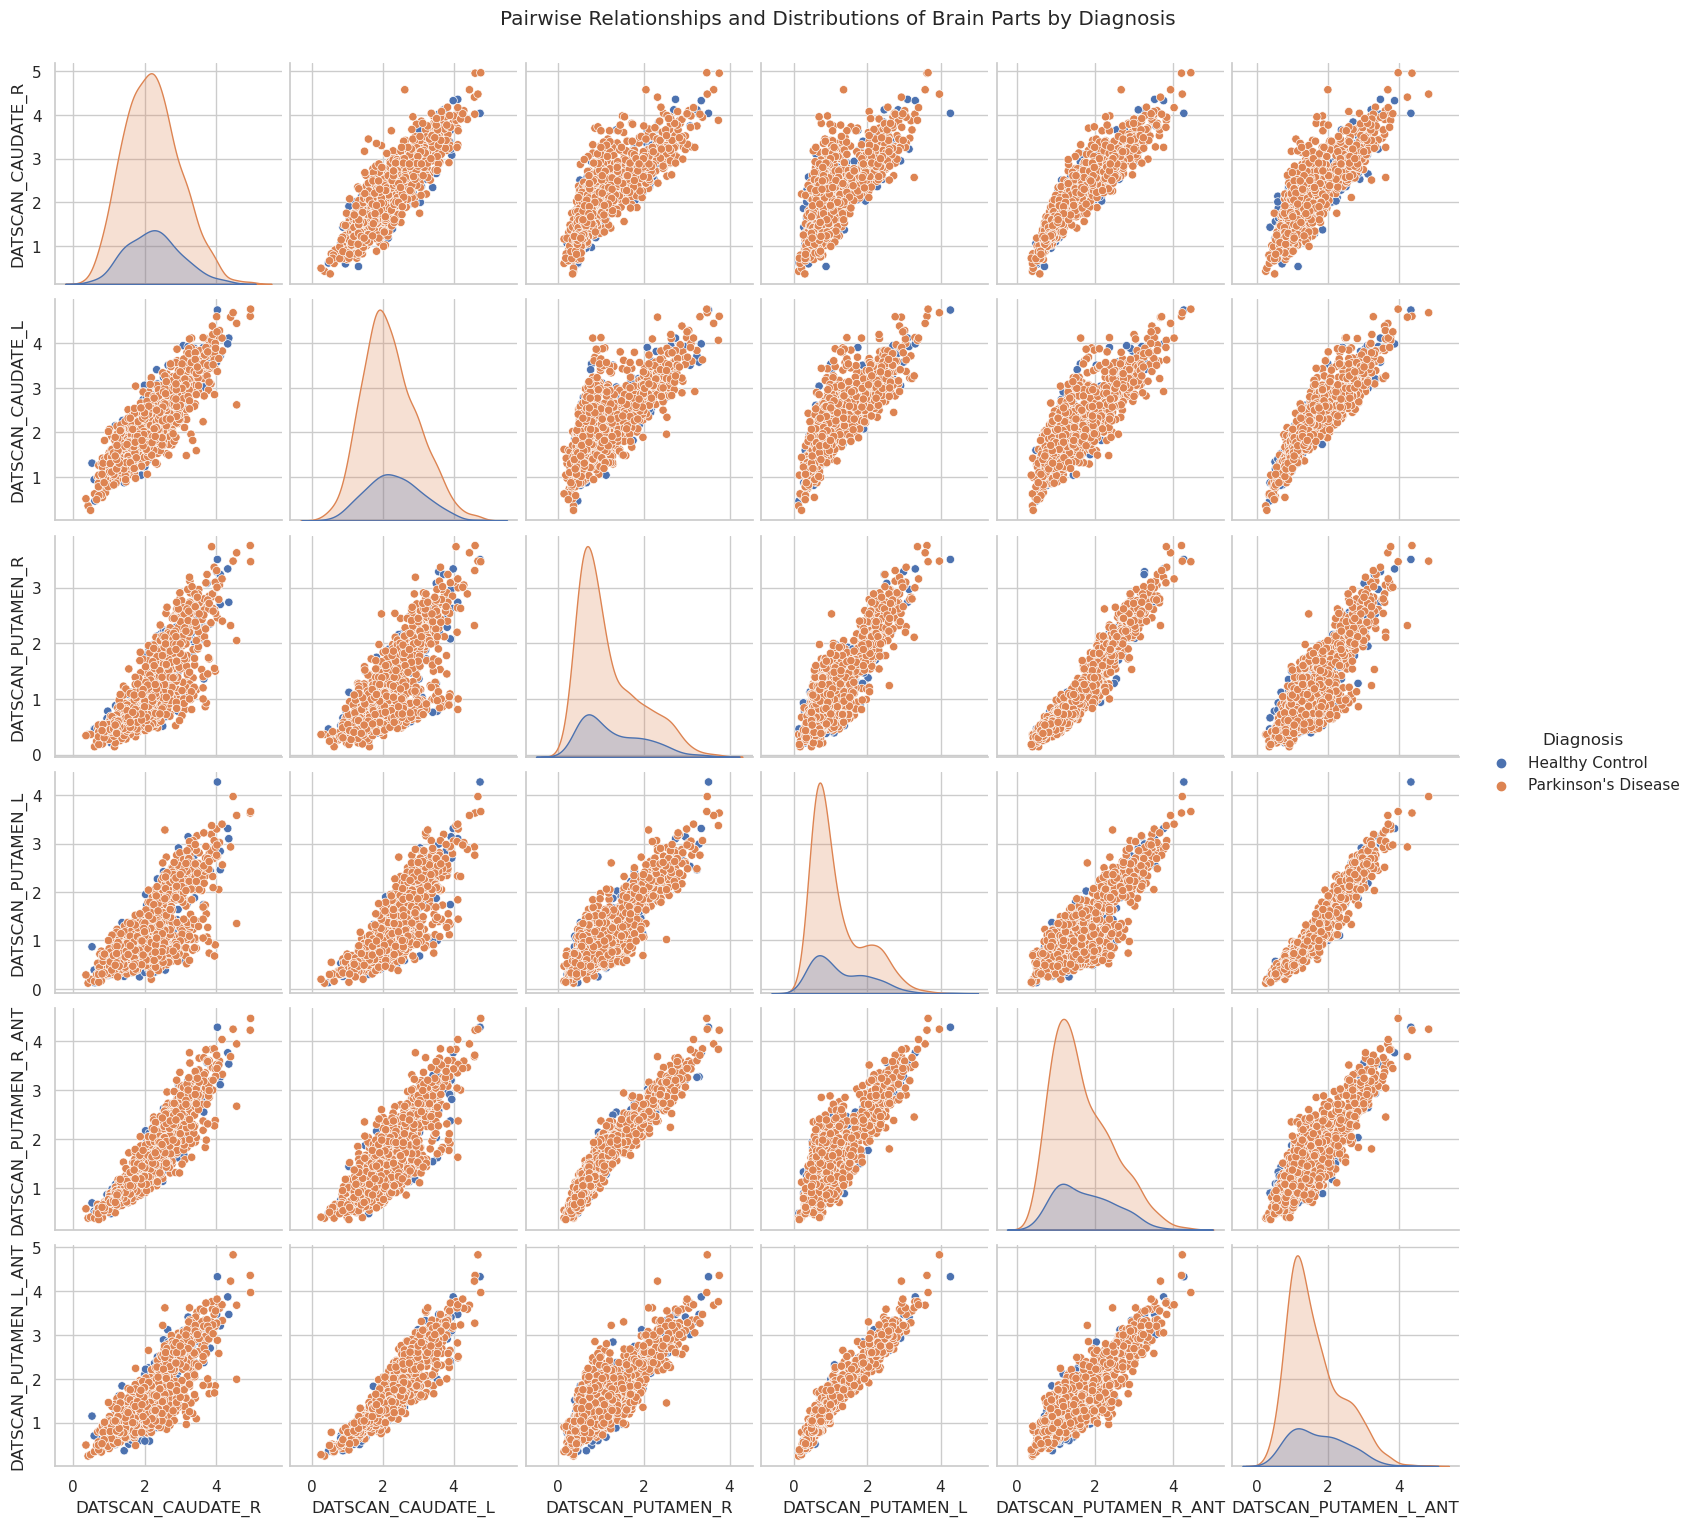

In [34]:
Image(filename='pairwise.png')

In [35]:
# Convert labels to numeric values using LabelEncoder
le = LabelEncoder()
y = le.fit_transform(imaging['Diagnosis'])

In [36]:
X = imaging_.drop(['PATNO', 'Diagnosis'], axis=1)

In [37]:
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X)

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_train_scaled, y, test_size=0.2, random_state=42)

In [42]:
model = LogisticRegression()

In [43]:
# Create and train the XGBoost model
#model = XGBClassifier()
model.fit(X_train, y_train)

LogisticRegression()

In [44]:
# Predict probabilities on the test set
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [34]:
# Calculate AU-ROC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f"Area Under the ROC Curve (AU-ROC) score: {roc_auc}")

Area Under the ROC Curve (AU-ROC) score: 0.5474709784411278


In [45]:
%%capture
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# Assuming you have X_train, y_train for training the model
# and X_test, y_test for evaluating the model

# Example: RandomForestClassifier training
model = RandomForestClassifier()
model.fit(X_train, y_train)

# Obtain predicted probabilities for positive class
y_probs = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.savefig('brain_roc.png')


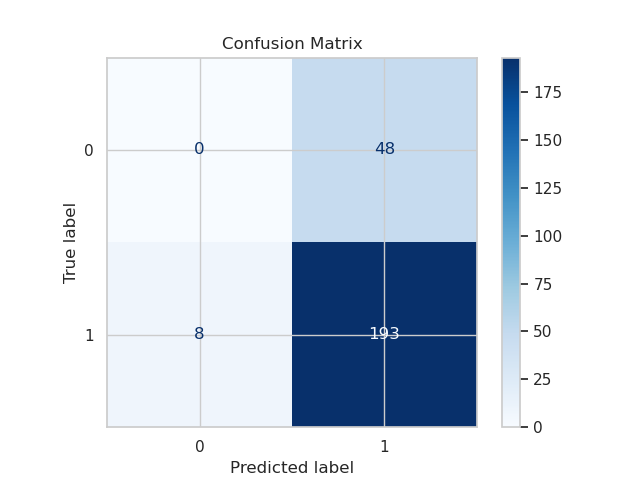

In [46]:
Image('brain_roc.png')

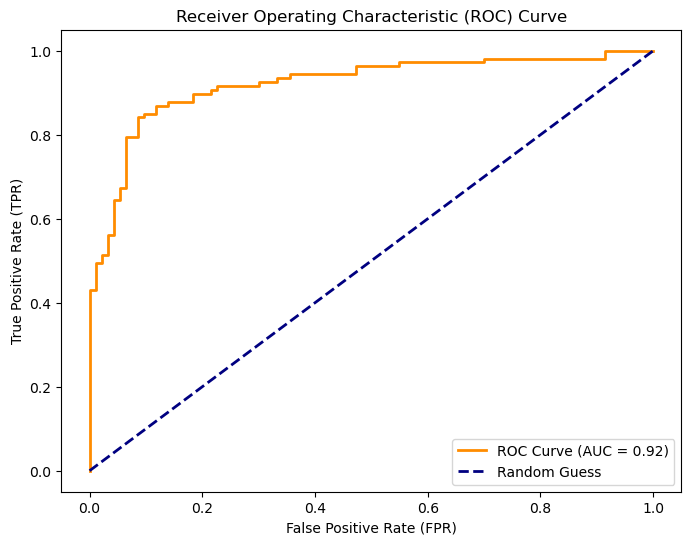

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc

# Generate synthetic data
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train a logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict probabilities for the positive class (class 1) on the test set
y_prob = model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC (Area Under the Curve)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



## Matrix of Gene IDs and Counts for Patients
- Loading the data from IR3/counts folder and extracting the associated last column (counts) of each patient file for their BL visit.


## Data Preprocessing STEP I
- We remove patients that have these mutations of genes: SNCA (ENRLSNCA), GBA (ENRLGBA), LRRK2 (ENRLLRRK2).
-  We only keep genes with the intersection of counts and quants with proteing coding and RNAincs.
- We remove the duplicated gene IDs in which they are also lowly expressed.
- We keep only patients with diagnosis of Health control or Parkinson disease.
- We check if there are some patients were they were taking dopamine drug, so we exclude them. Dopaminergic medication can impact the interpretation of experimental data or measurements and can alter gene expression patterns, so we need to remove them to have less biased data.

## Data Preprocessing STEP II
1. We remove lowely expressed genes, by keeping only genes that had more than five counts in at least 10% of the individuals, which left us with 21,273 genes

2. Similar DESeq2 but with numpy:  we estimated size factors, normalized the library size bias using these factors, performed independent filtering to remove lowly expressed genes using the mean of normalized counts as a filter statistic. This left us with 22969 genes

3. pyDESeq2: we apply a variance stabilizing transformation (vst) to accommodate the problem of unequal variance across the range of mean values.


4. limma: we used control samples to estimate the batch effect of the site, that we subsequently removed in both controls and cases. In experimental research, a batch effect is a systematic variation in data that can occur when data is collected from multiple sites (clinical centers). These factors can include differences in equipment, reagents, operators, or experimental conditions. Examples of batch effects: 
 - Differences in the equipment used to collect the data. For example, if you are using two different microarray platforms to measure gene expression, there may be differences in the way that the platforms detect and quantify gene expression.
 - Differences in the operators who collect the data. For example, if two different people are collecting RNA-seq data, they may have different levels of experience or expertise, which could lead to differences in the way that they process the samples.
 

5. using limma: we removed further confounding effects due to sex and RIN value. RIN value is a measure of the quality of RNA samples, and it can vary depending on the sample preparation method. Sex can also affect gene expression. If the effects of sex and RIN value are not removed, then the results of the analysis may be biased.


## Model Training
The code uses a Random Forest model to identify the most important features in a dataset. The code first performs
repeated stratified k-fold cross validation to train the Random Forest and compute the permutaion featute importanes. Then, the code counts the occurances of each features in the selected top features ist. Finally, the code gets the name of the final selected top features.

## Results and Evaluation
We present the results of the trained models, including performance metrics, accuracy, or any relevant evaluation measures. The model without preprocessing is with high recall score and low roc and auc score, and this means that the model is good to distinguishing the person with parkinson but not healthy people, therefore the model sounds very random.


## Conclusion
Summarize the key findings, limitations of the analysis, and potential future work or improvements. Offer closing remarks or suggestions for further exploration.

## References
- [**Parkinson’s Progression Markers Initiative (PPMI)**](https://www.ppmi-info.org/)

- [**A Machine Learning Approach to Parkinson’s Disease Blood Transcriptomics**](https://www.mdpi.com/2073-4425/13/5/727)

- [**Quality Control Metrics for Whole Blood Transcriptome Analysis in the Parkinson’s Progression Markers Initiative (PPMI)**](https://www.medrxiv.org/content/10.1101/2021.01.05.21249278v1)



<a id="matrixcreation"></a>
## Matrix of Gene IDs and Counts for Patients
 Loading the data from IR3/counts folder and extracting the associated last column (counts) of each patient file for their BL visit.

In [3]:
#reading the files which are in BL (Base line) visit.
specific_word = 'BL'
ending_pattern = '*.txt'
file_pattern = f'*{specific_word}*.{ending_pattern}'
file_paths = glob.glob(path_to_files + file_pattern)
# 'bl.txt' is a file that ccontains the name of the files with patient, BL, IR3, counts.
filename = 'bl.txt'
file_path_2 = os.path.join(path_to_files, filename)
bl_files = pd.read_csv(file_path_2,header=None)

# We define a function where we can take the second phrase seperated by dot. The second phrase 
# is the patient ID. So with this functin we want to get the patient IDs from their file's name
def function_names(fname):
    tokens=fname.split('.')
    return tokens[1]

# we create a list with the name of the each patients.
bl_list = [function_names(bl_files.iloc[i][0]) for i in range(len(bl_files))]

# here we read all the files with with base visit(BL) from the counts folder (where we have all the files
# for all the patients and all the visit).
list_bl_files = [dd.read_csv(path1/bl_files.iloc[i][0],skiprows=1,delimiter='\t') for i in range(len(bl_files))]


# we get th last columns of each file in the list
last_columns = [ddf.iloc[:, -1:] for ddf in list_bl_files]

# concatinating the list of the columns in a single file.
single_file = dd.concat(last_columns, axis=1)

# we change the name of the each columns with the patient numbers.
single_file.columns = bl_list

# we get the Geneid column and convert it to dask dataframe
pd_tmp_file = list_bl_files[3].compute()
geneid = pd_tmp_file['Geneid']
ddf_geneid = dd.from_pandas(geneid, npartitions=1)

# here we set the Geneid column as the index of the matrix.
ddf_new_index = single_file.set_index(ddf_geneid)

# converting to pandas data frame and saving.
ir3_counts = ddf_new_index.compute()
ir3_counts.to_csv(path2/"matrix_ir3_counts_bl.csv")

/home/znazari/anaconda3/lib/python3.9/site-packages/dask/dataframe/multi.py:1291: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


<a id="preprocessing"></a>
## Data Preprocessing STEP I

- We remove patients that have these gene mutations : SNCA (ENRLSNCA), GBA (ENRLGBA), LRRK2 (ENRLLRRK2).
-  We only keep genes with the intersection of counts and quants with proteing coding and RNAincs.
- We remove the duplicated gene IDs in which they are also lowly expressed.
- We keep only patients with diagnosis of Health control or Parkinson disease.
- We check if there are some patients were they were taking dopomine drug, so we exclude them.


In [3]:
# reading the file
read_ir3_counts = pd.read_csv(path2/"matrix_ir3_counts_bl.csv")
# setting the geneid as indexing column
read_ir3_counts.set_index('Geneid', inplace=True)
# result with removing the after dot (.) value, i.e. the version of the geneIDs is removed.
read_ir3_counts.index =read_ir3_counts.index.str.split('.').str[0]


#here we delete the duplicated gene IDs, first we find them then remove them from the gene IDs
# as they are duplicated and also they are very lowly expressed either zero or one in rare caes.

# Check for duplicate index values
is_duplicate = read_ir3_counts.index.duplicated()

# Display the duplicate index values
duplicate_indices = read_ir3_counts.index[is_duplicate]

# drop them (duplicated indices and their copies are deleted, 45 duplicatd indices and 90 are dropped)
to_be_deleted = list(duplicate_indices)
read_ir3_counts = read_ir3_counts.drop(to_be_deleted)

# we read the file where we have an intersection of geneIDs in IR3, counts, quant
intersect = pd.read_csv(path2/"intersect_IR3_ENG_IDs_LincRNA_ProtCoding_counts_quant_gene_transcript_only_tot_intsersect.txt")
intersection = read_ir3_counts.index.intersection(intersect['[IR3_gene_counts] and [IR3_quant_gene] and [IR3_quant_trans] and [lncRNA+ProtCod]: '])
filtered_read_ir3_counts = read_ir3_counts.loc[intersection]

# reading the file which contains diagnosis
diago=pd.read_csv(path3/"Participant_Status.csv", header=None )
diago1=diago.rename(columns=diago.iloc[0]).drop(diago.index[0]).reset_index(drop=True)

#this is to remove patients that have these diseases: SNCA (ENRLSNCA), GBA (ENRLGBA), LRRK2 (ENRLLRRK2)
filtered_SNCA_GBA_LRRK2 = diago1[(diago1['ENRLSNCA'] == "0")& (diago1['ENRLGBA'] == "0")& (diago1['ENRLLRRK2'] == "0")]

#patients with their diagnosis
patinets_diagnosis = filtered_SNCA_GBA_LRRK2[['PATNO','COHORT_DEFINITION']].reset_index(drop=True)

# Define the particular names to keep
names_to_keep = ['Healthy Control', "Parkinson's Disease"]


# Filter the dataframe based on the specified names
PK_HC_pateints = patinets_diagnosis[patinets_diagnosis['COHORT_DEFINITION'].isin(names_to_keep)]

# Get the list of patient IDs with diagnosis from the second dataframe
patient_ids_with_diagnosis = PK_HC_pateints['PATNO']
list_patients=list(patient_ids_with_diagnosis)

# Filter the columns in the first dataframe based on patient IDs with diagnosis
rna_filtered = filtered_read_ir3_counts.filter(items=list_patients)

# We read a file that contains the Patient IDs that they were taking dopomine drugs, so they needed to be excluded.
patient_dopomine = pd.read_csv(path2/'Patient_IDs_taking_dopamine_drugs.txt',delimiter='\t',  header=None)
patient_dopomine = patient_dopomine.rename(columns={0: 'Pateint IDs'})
ids_to_remove = patient_dopomine['Pateint IDs'].tolist() # put the patient IDs to list
strings = [str(num) for num in ids_to_remove] # convert them as string

# The code is iterating over each column name in rna.columns and checking if any of the strings in the strings list 
# are present in that column name. If none of the strings are found in the column name,
# then that column name is added to the new_columns list.
new_columns = [col for col in rna_filtered.columns if not any(string in col for string in strings)] 
rna_filtered = rna_filtered[new_columns]
# there were no column name (patints that use druf in this list) to be excluded in our case.
# IN CASE THERE WERE SOME PATIENTS TO BE REMOVED, the diagnosis file below needs to be amended too.

rna_filtered.to_csv(path2/'ir3_rna_step1.csv', index=True)

# we keep only the patients that are common in the two dataframes:
common_patient_ids = list(set(PK_HC_pateints['PATNO']).intersection(rna_filtered.columns))
patient11_filtered = PK_HC_pateints[PK_HC_pateints['PATNO'].isin(common_patient_ids)]
patient11_filtered.reset_index(drop=True)

# we save the output into data folder
patient11_filtered.to_csv(path2/'patients_HC_PK_diagnosis.csv', index=False)

In [4]:
diago1

,PATNO,COHORT,COHORT_DEFINITION,ENROLL_DATE,ENROLL_STATUS,STATUS_DATE,ENROLL_AGE,INEXPAGE,AV133STDY,PPMI_ONLINE_ENROLL,...,COMMENTS,CONDATE,ENRLPINK1,ENRLPRKN,ENRLSRDC,ENRLHPSM,ENRLRBD,ENRLLRRK2,ENRLSNCA,ENRLGBA
0,3000,2,Healthy Control,02/2011,enrolled,05/2021,69.1,INEXHC,0,NO,...,NaN,06/2021,0,0,0,0,0,0,0,0
1,3001,1,Parkinson's Disease,03/2011,enrolled,09/2021,65.1,INEXPD,0,NO,...,NaN,06/2021,0,0,1,0,0,0,0,0
2,3002,1,Parkinson's Disease,03/2011,enrolled,09/2021,67.6,INEXPD,0,NO,...,NaN,06/2021,0,0,1,0,0,0,0,0
3,3003,1,Parkinson's Disease,04/2011,enrolled,01/2022,56.7,INEXPD,0,NO,...,NaN,06/2021,0,0,1,0,0,0,0,0
4,3004,2,Healthy Control,04/2011,enrolled,01/2022,59.4,INEXHC,0,YES,...,NaN,06/2021,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2346,162994,1,Parkinson's Disease,NaN,screened,07/2022,NaN,INEXPD,0,NO,...,NaN,NaN,0,0,1,0,0,0,0,0
2347,163265,1,Parkinson's Disease,NaN,screened,07/2022,NaN,INEXPD,0,YES,...,NaN,NaN,0,0,1,0,0,0,0,0
2348,164900,1,Parkinson's Disease,NaN,screened,07/2022,NaN,INEXPD,0,NO,...,NaN,NaN,0,0,1,0,0,0,0,0
2349,167222,1,Parkinson's Disease,NaN,screened,08/2022,NaN,INEXPD,0,NO,...,NaN,NaN,0,0,1,0,0,0,0,0


<a id="preprocessin2"></a>
## Data Preprocessing STEP II

1. Removing lowely expressed genes, by keeping only genes that had more than five counts in at least 10% of the individuals, which left us with 25317 genes

2. Similar DESeq2: we estimated size factors, normalized the library size bias using these factors, performed independent filtering to remove lowly expressed genes using the mean of normalized counts as a filter statistic. This left us with 22969 genes

3. DESeq2: we apply a variance stabilizing transformation to accommodate the problem of unequal variance across the range of mean values.

4. limma: we used control samples to estimate the batch effect of the site, that we subsequently removed in both controls and cases 

5. limma: we removed further confounding effects due to sex and RIN value.

In [4]:
rna_step1 = pd.read_csv(path2/'ir3_rna_step1.csv')
rna_step1.set_index('Geneid', inplace=True)

In [5]:
# 1. Removing lowely expressed genes, by keeping only genes that had more than five counts in 
#at least 10% of the individuals, which left us with 25317 genes
gene_counts = rna_step1.sum(axis=1)
gene_mask = gene_counts > 5
gene_percentage = (rna_step1 > 5).mean(axis=1)
percentage_mask = gene_percentage >= 0.1
filtered_data = rna_step1[gene_mask & percentage_mask]

# we estimated size factors, normalized the library size bias using these factors,
# performed independent filtering to remove lowly expressed genes using the mean of normalized counts as a filter statistic.
#This left us with 22969 genes
# Step 1: Estimating Size Factors
library_sizes = filtered_data.sum(axis=0)
median_library_size = np.median(library_sizes)
size_factors = library_sizes / median_library_size

# Step 2: Normalizing Library Size Bias
normalized_data = filtered_data.divide(size_factors, axis=1)

# Step 3: Performing Independent Filtering
mean_normalized_counts = normalized_data.mean(axis=1)
threshold = 5  # Adjust this threshold as desired
filtered_data2 = normalized_data.loc[mean_normalized_counts >= threshold]


#we need to round and make the counts values integer because that what deseq2 type requires.
filtered_data2 = filtered_data2.round().astype(int)
filtered_data2 = filtered_data2.T
# we make the patient ids as string type otherwise we get warning when transforming to deseq data set.
filtered_data2.index = filtered_data2.index.astype(str)
filtered_data2.to_csv(path2/'ir3_rna_step2.csv', index=True)


diagnosis = pd.read_csv(path2/'patients_HC_PK_diagnosis.csv')
patnn=diagnosis.set_index("PATNO")
# renaming the column as "condition" is necessary for deseq transformation.
patnn.rename(columns={'COHORT_DEFINITION': 'condition'}, inplace=True)
patnn.index = patnn.index.astype(str)

In [6]:
# here is to make a dese data set:
dds = DeseqDataSet(
    counts=filtered_data2,
    clinical=patnn,
    design_factors="condition"
)
#dds.obs # show patients diagnosis
#dds.X # show array of counts
# dds.var # show Geneids

# Perform VST transformation
dds.vst()

# Here we get the VST data which are in the numpy form.
vst_transformed_dds=dds.layers["vst_counts"]

# We convert the numpy data to pandas dataframe
pd_vst= pd.DataFrame(vst_transformed_dds)

# the above file does not have patient IDs name as well as Gene IDs so we need to take it from the other
# file and then add it to bare dataframe file

ir3_rna_step2 = pd.read_csv(path2/'ir3_rna_step2.csv')
# patient IDs 
patient_ids = ir3_rna_step2['Unnamed: 0']

# set them as the index of rows: 
pd_vst.set_index(patient_ids, inplace = True)

# taking the gene IDs properly as a list format
geneids = list(ir3_rna_step2.columns)[1:]

# add the list of columns to the pandas dataframe file:
pd_vst.columns = geneids
# Saving the matrix with vst applied into csv file.
pd_vst.to_csv(path2/'ir3_rna_step_vst.csv', index=True)


TypeError: DeseqDataSet.__init__() got an unexpected keyword argument 'clinical'

# RIN and SEX effects to be removed 

In [ ]:
sex_rin_data = pd.read_csv(path2/'Patient_IDs_RNA_sample_RIN_sex_CNO_diagnosis.txt',delimiter='\t')
sex_rin_data 

In [ ]:
unique_values = sex_rin_data['CLINICAL_EVENT'].unique()
unique_values  

In [ ]:
# we need to keep only base line visit data of patient.
#baseline_df = sex_rin_data[sex_rin_data['CLINICAL_EVENT'] == 'BL']
# Filter the DataFrame to keep rows with 'BL' and 'SC' values in the 'CLINICAL_EVENT' column
baseline_df = sex_rin_data[sex_rin_data['CLINICAL_EVENT'].isin(['BL'])]


In [ ]:
diagnosis = pd.read_csv(path2/'patients_HC_PK_diagnosis.csv')
diagnosis

In [ ]:
patient_ids = diagnosis['PATNO']
filtered_df_sex_rin = baseline_df[baseline_df['ALIAS_ID'].isin(patient_ids)]
filtered_df_sex_rin

In [ ]:
# Check if all patient IDs in diagnosis exist in filtered_df_sex_rin
all_exist = diagnosis['PATNO'].isin(baseline_df['ALIAS_ID']).all()

# Print the result
if all_exist:
    print("All patient IDs in other_df exist in big_df.")
else:
    print("Not all patient IDs in other_df exist in big_df.")
# I note that all the patient IDs that I analysis are note only in BL some of them are in V01.
# I need to find those that are in the v01 and only add them not the rest.

In [ ]:
duplicates = filtered_df_sex_rin['ALIAS_ID'].duplicated()
duplicate_rows = filtered_df_sex_rin[duplicates]


In [ ]:
# Find the duplicated patient IDs in the filtered DataFrame
duplicates = filtered_df_sex_rin['ALIAS_ID'].duplicated(keep=False)

# Filter the DataFrame to keep only the duplicated rows
duplicate_rows = filtered_df_sex_rin[duplicates]

# Sort the duplicate rows by the patient ID
duplicate_rows_sorted = duplicate_rows.sort_values('ALIAS_ID')

# Print the duplicate rows
duplicate_rows_sorted


<a id="training"></a>
## Model Training 

We have trained the data where log and cpm filterization is applied as well as the effect of sex and RIN covariate is removed, and left us with 530 top genes, all done using limma

In [5]:
# with 530 genes:
ir3_rna_step_vst =  pd.read_csv(path2/'mydata_Log_CPM_filtered_bact_sex_effect_removed_RIN_covariate_top_530_limma.txt',delimiter='\t' )

ir3_rna_step_vst.rename(columns={"Unnamed: 0": "PATNO"}, inplace=True)

ir3_rna_step_vst.set_index("PATNO", inplace = True)

diagnosis = pd.read_csv(path2/'patients_HC_PK_diagnosis.csv')

# mapping diagnosis to zero and one.
diagnosis['COHORT_DEFINITION'] = diagnosis['COHORT_DEFINITION'].map({'Healthy Control': 0, "Parkinson's Disease": 1})

In [6]:
# with all the filtered genes:
ir3_rna_step_vst =  pd.read_csv(path2/'mydata_Log_CPM_filtered_bact_sex_effect_removed_RIN_covariate.txt',delimiter='\t' )



diagnosis = pd.read_csv(path2/'patients_HC_PK_diagnosis.csv')

# mapping diagnosis to zero and one.
diagnosis['COHORT_DEFINITION'] = diagnosis['COHORT_DEFINITION'].map({'Healthy Control': 0, "Parkinson's Disease": 1})

In [12]:
ir3_rna_step_vst

,3000,3001,3002,3003,3004,3006,3007,3008,3009,3010,...,4121,4122,4123,4124,4125,4126,4135,4136,4139,41410
ENSG00000000419,3.845119,5.213262,4.837730,5.101270,4.974751,4.825708,5.011214,5.229956,5.174531,5.284571,...,4.451699,5.408345,5.247058,4.584573,4.398598,5.449524,5.015613,3.987076,5.496642,4.963686
ENSG00000000457,5.648852,6.202708,5.624314,6.067816,6.092646,6.223112,6.003440,6.010872,6.272480,6.285266,...,5.863215,6.422896,6.368654,6.114092,5.798945,6.383039,6.290690,5.179048,6.293745,6.058590
ENSG00000000460,3.817007,4.095830,4.012751,4.262379,3.969580,4.374808,4.417553,4.331596,4.675491,4.348990,...,3.957820,4.518421,4.424952,4.145217,4.194468,4.628795,4.747158,3.569694,4.025577,4.268701
ENSG00000000938,8.463275,8.810743,8.368607,8.466923,8.927912,9.043402,8.681277,8.235545,8.067889,8.631065,...,8.416943,9.104202,8.838484,9.193292,8.217039,8.772340,8.497247,8.612951,8.695999,8.676493
ENSG00000000971,1.944928,3.384911,2.522713,4.085667,3.693875,2.544924,3.968554,4.085922,4.811027,4.093739,...,2.209538,2.390307,3.974330,2.196031,2.196303,3.910535,4.403068,2.359305,2.445675,3.267041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000285219,2.721748,1.638440,3.771521,1.812421,2.549122,2.058582,2.125234,1.765596,2.069582,1.764143,...,2.495753,1.830501,1.218611,2.165035,3.126425,1.943526,0.648852,2.959793,2.179546,2.136740
ENSG00000285230,2.322872,2.517009,2.599599,2.386956,2.851771,2.737816,2.894924,2.388526,2.458358,2.695723,...,2.169890,2.481177,2.779666,2.643108,2.415556,2.438769,2.464313,2.474065,2.487454,2.544368
ENSG00000285280,4.541140,1.709681,2.196385,2.727775,2.760335,2.204436,2.655007,2.044956,1.865374,1.846651,...,2.344181,2.573584,2.253876,2.459218,3.058924,2.916741,2.501802,2.977444,2.196541,2.727432
ENSG00000285399,5.099339,5.353763,4.708896,5.048748,5.349433,5.567314,5.192088,5.066864,5.211345,5.326240,...,5.208116,5.197208,5.421681,5.656614,5.370812,5.384910,5.832674,4.774830,4.800063,5.287198


In [ ]:
# to see how many Parkinson and Healthy patients we have
diagnosis['COHORT_DEFINITION'].value_counts()

In [9]:
# Initialize evaluation metric lists
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []
confusion_matrices = []

# Perform the iterations
for _ in range(20):
    # Split the data into training and test sets
    # X_train: train data of RNA,  X_test: test data of RNA 
    # y_train: train diagnosis, y_test: test diagnosis
    X_train, X_test, y_train, y_test = train_test_split(ir3_rna_step_vst, diagnosis['COHORT_DEFINITION'], test_size=.3)
    
    # Create and fit the Random Forest model
   # model_rf = RandomForestClassifier(n_estimators=100)
    model_rf = XGBClassifier(n_estimators=100)
    model_rf.fit(X_train, y_train)

    # Evaluate the model and store the metrics
    accuracy_scores.append(accuracy_score(y_test, model_rf.predict(X_test)))
    precision_scores.append(precision_score(y_test, model_rf.predict(X_test)))
    recall_scores.append(recall_score(y_test, model_rf.predict(X_test)))
    f1_scores.append(f1_score(y_test, model_rf.predict(X_test)))
    roc_auc_scores.append(roc_auc_score(y_test, model_rf.predict(X_test)))
    confusion_matrices.append(confusion_matrix(y_test, model_rf.predict(X_test)))

# Calculate the average evaluation metrics
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_roc_auc = np.mean(roc_auc_scores)
avg_confusion_matrix = np.mean(confusion_matrices, axis=0)

# Print the average evaluation metrics
print('Average Evaluation Metrics')
print('Accuracy:  ', avg_accuracy)
print('Precision: ', avg_precision)
print('Recall:    ', avg_recall)
print('F1:        ', avg_f1)
print('ROC-AUC:   ', avg_roc_auc)
print('\nAverage Confusion Matrix\n', avg_confusion_matrix)


Average Evaluation Metrics
Accuracy:   0.6574285714285715
Precision:  0.6965705525943869
Recall:     0.876314546478481
F1:         0.7752940776747334
ROC-AUC:    0.540701188516332

Average Confusion Matrix
 [[ 11.55  45.25]
 [ 14.7  103.5 ]]


In [ ]:
%%time
# 'ir3_rna_step_vst' is my RNA-seq data and 'diagnosis' is the corresponding labels

# Set the number of repetitions for Random Forest training
num_repetitions = 1

# Set the number of folds for repeated stratified 10-fold cross-validation
num_folds = 10

# Set the random seed for reproducibility
random_seed = 42

# Define the function to train a Random Forest model and compute permutation feature importances
def train_rf_with_permutation_importance(X_train, y_train, X_test, y_test, num_features):
    rf_model = RandomForestClassifier(n_estimators=1000, random_state=random_seed)
    rf_model.fit(X_train, y_train)

    perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=20, random_state=random_seed)
    feature_importance = perm_importance.importances_mean

    # Get the indices of the top features based on their importance
    top_feature_indices = np.argsort(feature_importance)[-int(np.sqrt(num_features)):]
    
    return top_feature_indices

# Initialize lists to store the selected top features across all splits
selected_top_features = []

# Create the repeated stratified k-fold cross-validator
cv = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=random_seed)

# Repeat the process for a total of 'num_repetitions' times
for repetition in range(num_repetitions):
    print(f"Repetition {repetition+1}/{num_repetitions}")

    # Perfo0rm repeated stratified k-fold cross-validation
    for train_idx, test_idx in cv.split(ir3_rna_step_vst, diagnosis['COHORT_DEFINITION']):
        X_train, X_test = ir3_rna_step_vst.iloc[train_idx], ir3_rna_step_vst.iloc[test_idx]
        y_train, y_test = diagnosis['COHORT_DEFINITION'].iloc[train_idx], diagnosis['COHORT_DEFINITION'].iloc[test_idx]

        # Get the selected top features for this split
        top_features_split = train_rf_with_permutation_importance(X_train, y_train, X_test, y_test, len(ir3_rna_step_vst.columns))

        # Add the selected top features to the list
        selected_top_features.extend(top_features_split)

# Count the occurrences of each feature in the selected_top_features list
feature_counts = pd.Series(selected_top_features).value_counts()

# Get the indices of the top features based on their overall occurrence
final_top_feature_indices = feature_counts.index[:2*int(np.sqrt(len(ir3_rna_step_vst.columns)))]

# Get the names of the final selected top features
final_top_features = ir3_rna_step_vst.columns[final_top_feature_indices]
final_top_features.to_csv(path2/"important_features.csv", index = True)




In [ ]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

# Assuming you have X_train and y_train prepared
X_train, X_test, y_train, y_test = train_test_split(ir3_rna_step_vst, diagnosis['COHORT_DEFINITION'], test_size=.3)

model = RandomForestClassifier()
model.fit(X_train, y_train)

# Get feature importances
importances = model.feature_importances_

# Sort the importances in descending order
sorted_indices = importances.argsort()[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = [feature_names[i] for i in sorted_indices]

# Select only the top 50 features
top_50_indices = sorted_indices[:50]
top_50_importances = sorted_importances[:50]
top_50_feature_names = sorted_feature_names[:50]

# Visualize the top 50 feature importances
plt.figure(figsize=(15, 8))
plt.bar(range(len(top_50_importances)), top_50_importances, tick_label=top_50_feature_names)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 50 Feature Importances')
plt.show()

# Select the top 50 features from the original dataset
X_train_top_50 = X_train[top_50_feature_names]


<a id="results"></a>
## Results and Evaluation 

Present the results of the trained models, including performance metrics, accuracy, or any relevant evaluation measures. Interpret the findings and discuss the implications. Include visualizations or tables to support the results.

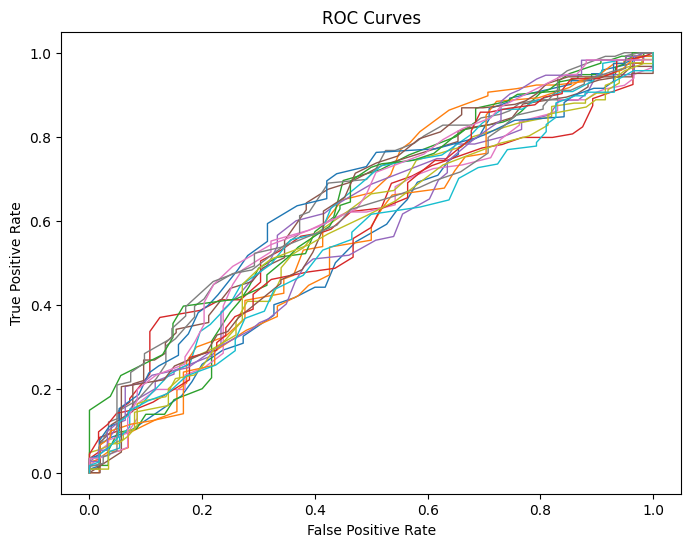

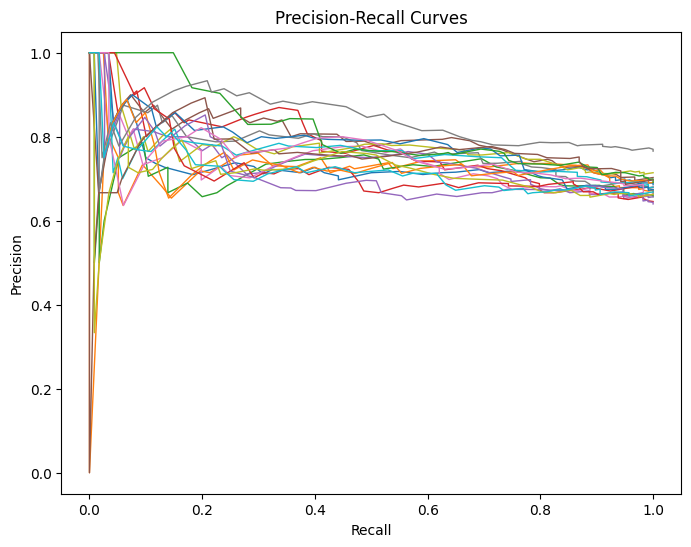

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
        
# Initialize lists to store the ROC and precision-recall data
roc_curves = []
precision_recall_curves = []

# Perform the iterations
for _ in range(20):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(ir3_rna_step_vst, diagnosis['COHORT_DEFINITION'], test_size=.3)
    
    # Create and fit the Random Forest model
    model_rf = RandomForestClassifier(n_estimators=100)
    model_rf.fit(X_train, y_train)
    
    # Calculate the ROC curve
    fpr, tpr, _ = roc_curve(y_test, model_rf.predict_proba(X_test)[:, 1])
    roc_curves.append((fpr, tpr))
    
    # Calculate the precision-recall curve
    precision, recall, _ = precision_recall_curve(y_test, model_rf.predict_proba(X_test)[:, 1])
    precision_recall_curves.append((precision, recall))

# Plot ROC curves
plt.figure(figsize=(8, 6))
for fpr, tpr in roc_curves:
    plt.plot(fpr, tpr, lw=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.show()

# Plot precision-recall curves
plt.figure(figsize=(8, 6))
for precision, recall in precision_recall_curves:
    plt.plot(recall, precision, lw=1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.show()


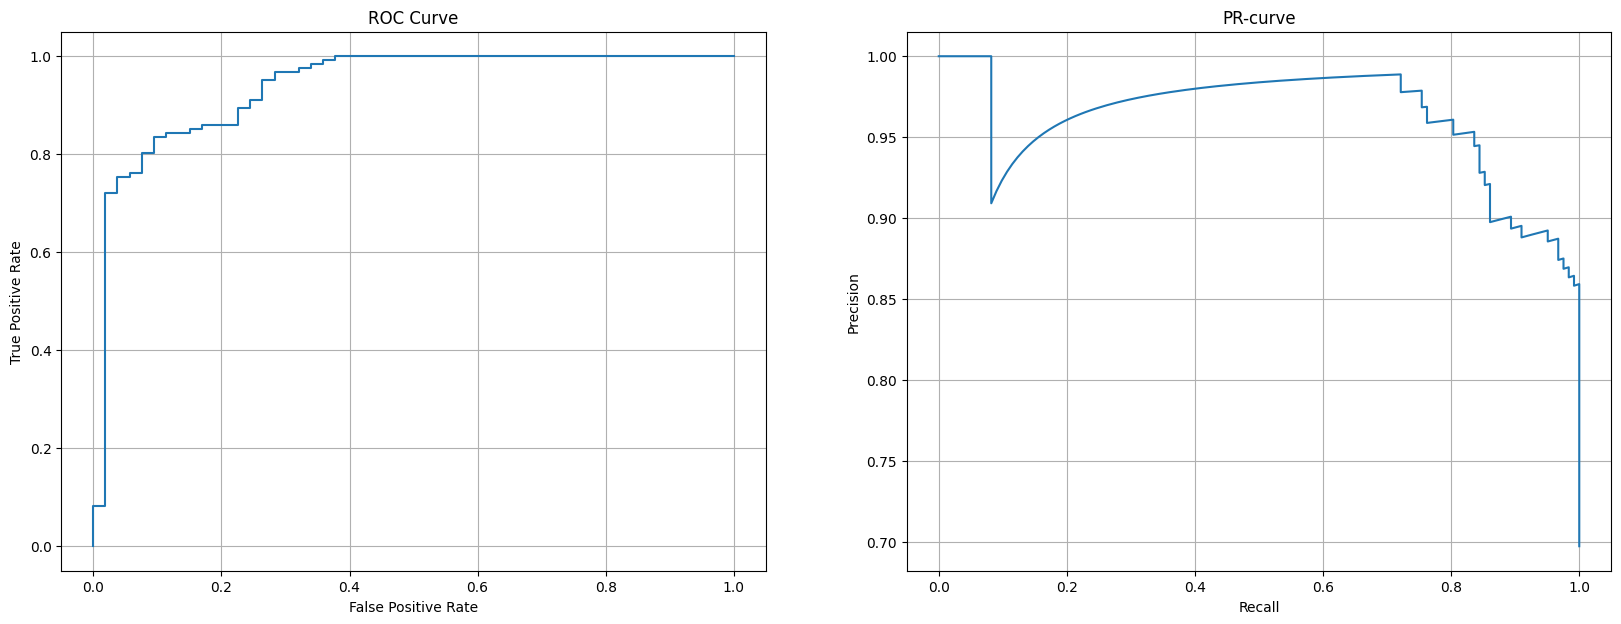

In [12]:
#ploting roc curve and precision recall curve
roc = roc_curve(y_test,model_rf.predict_proba(X_test)[:,1])
pr  = precision_recall_curve(y_test,model_rf.predict_proba(X_test)[:,1])

f = plt.figure(figsize=(20,7))
ax = f.add_subplot(121)
ax.plot(roc[0],roc[1])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
ax.set_title('ROC Curve')
ax.grid(which='both')
ax = f.add_subplot(122)
ax.plot(pr[1],pr[0])
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.set_title('PR-curve')
ax.grid(which='both')
plt.show()

### PATHWAY ANALYSIS

In [9]:
# Reading Pathway database for KEGG 2017
    pathway_kegg = pd.read_csv(path2/"KEGG_R_downloaded_pathways_noURLs_hsa_symbol_25ott2017.txt",delimiter='\t', header=None)

In [10]:
pathway_kegg

,0,1,2,3,4,5,6,7,8,9,...,1263,1264,1265,1266,1267,1268,1269,1270,1271,1272
0,Glycolysis_vs_Gluconeogenesis_:::_hsa00010,AKR1A1,ADH1A,ADH1B,ADH1C,ADH4,ADH5,ADH6,GALM,ADH7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Citrate_cycle_.TCA_cycle._:::_hsa00020,CS,DLAT,DLD,DLST,FH,IDH1,IDH2,IDH3A,IDH3B,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Pentose_phosphate_pathway_:::_hsa00030,GLYCTK,FBP1,PRPS1L1,ALDOA,ALDOB,RPIA,ALDOC,G6PD,PGLS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Pentose_and_glucuronate_interconversions_:::_h...,AKR1A1,UGT2B11,UGT2A1,AKR1B1,DHDH,GUSB,CRYL1,DCXR,UGT2B28,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Fructose_and_mannose_metabolism_:::_hsa00051,FUK,FBP1,ALDOA,ALDOB,ALDOC,AKR1B1,TKFC,GMDS,GMPPB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316,Hypertrophic_cardiomyopathy_.HCM._:::_hsa05410,CACNG3,CACNG2,DAG1,ACE,DES,DMD,EMD,ITGA11,CACNG5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
317,Arrhythmogenic_right_ventricular_cardiomyopath...,CDH2,CACNG3,CACNG2,CTNNA1,CTNNA2,CTNNB1,DAG1,DES,DMD,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318,Dilated_cardiomyopathy_.DCM._:::_hsa05414,LOC102723407,CACNG3,CACNG2,ADCY1,ADCY2,ADCY3,ADCY5,ADCY6,ADCY7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
319,Viral_myocarditis_:::_hsa05416,LOC102723407,CXADR,CD55,DAG1,DMD,EIF4G1,EIF4G2,ABL1,FYN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## The Main Code ##

Machine Learning paradigm

Within a repeated stratified, (to tackle 1: the control-patient mismatch, 2: 10-fold cross-validation framework, with 3: 20 iterations for rubostness), we trained multiple RF models with 100 repetitions, where each repetition used a different seed of the random generation process  to evaluate permutation feature importance measures. 

Each forest was grown using 1000 trees, a sufficient value to allow the algorithm to reach a stable plateau of the out-of-bag internal error. The features selected at each split were square root of (f) with f being the overall number of genes, which is the default value for this parameter.

We determined the overall feature importance ranking by averaging over the 100 repetitions. 

We are training random forest for 200 * 100 = 20,000 times. In the following code each of 100 random forest will be trained with 200 different indexing for taining and testing data. In other words we use a single state of random forest for 200 different combination of training and testing.

Cosidering that each permutaion importance uses 10 times shuffling of the value and resuing the random forest, in overal random forest will be used 200,000 times.


Note: The n_repeats parameter in the permutation_importance() function in Scikit-Learn controls how many times a feature is randomly shuffled and the model is retrained to evaluate its importance. A higher value of n_repeats will result in a more accurate estimate of feature importance, but it will also be more computationally expensive.

In [ ]:
import numpy as np
import pandas as pd
import numpy as np
import os
import glob
import functools
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score
'''
Machine Learning paradigm

Within a repeated stratified, (to tackle 1: the control-patient mismatch, 2: 10-fold cross-validation framework, with 3: 20 iterations), we trained multiple RF models with 100 repetitions, where each repetition used a different seed of the random generation process  to evaluate permutation feature importance measures. 

Each forest was grown using 1000 trees, a sufficient value to allow the algorithm to reach a stable plateau of the out-of-bag internal error. The features selected at each split were square root of (f) with f being the overall number of genes, which is the default value for this parameter.

We determined the overall feature importance ranking by averaging over the 100 repetitions. 

We are training random forest for 200 * 100 = 20,000 times. In the following code each of 100 random forest will be trained with 200 different indexing for taining and testing data. In other words we use a single state of random forest for 200 different combination of taining and testing.

Cosidering that each permutaion importance uses 10 times shuffling of the value and resuing the random forest, in overal random forest will be used 200,000 times.


Note: The n_repeats parameter in the permutation_importance() function in Scikit-Learn controls how many times a feature is randomly shuffled and the model is retrained to evaluate its importance. A higher value of n_repeats will result in a more accurate estimate of feature importance, but it will also be more computationally expensive.

'''
# Loading the already preprocessed data:

path2 = Path("/home/znazari/data") # where the output data will be saved at the end.

# with all the filtered genes:

ir3_rna_step_vst =  pd.read_csv(path2/'mydata_Log_CPM_filtered_bact_sex_effect_removed_RIN_covariate.txt',delimiter='\t' )

diagnosis = pd.read_csv(path2/'patients_HC_PK_diagnosis.csv')

# mapping diagnosis to zero and one.
diagnosis['COHORT_DEFINITION'] = diagnosis['COHORT_DEFINITION'].map({'Healthy Control': 0, "Parkinson's Disease": 1})

# X: feature matrix, y: the target variable

X=ir3_rna_step_vst.T
y=diagnosis['COHORT_DEFINITION']

# Initialize repeated stratified K-fold cross-validation
n_splits = 10 #10
n_repeats = 1 #20
rkf = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=42)



# Define the parameters for the Random Forest
n_estimators = 50 #1000
max_features = int(np.sqrt(X.shape[1]))  # Square root of the total number of features

# Initialize arrays to store feature importance scores
feature_importance_scores = np.zeros((1, X.shape[1]))  # 100 repetitions, n_features

# Loop through each repetition
for repetition in range(1):
    
    # Loop through each fold
    for train_index, test_index in rkf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y[test_index]
        
        # Initialize a Random Forest model
        rf_model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features, random_state=repetition)

        # Fit the Random Forest model, we fit the X training sample with its associated y labels.
        rf_model.fit(X_train, y_train)

        # Calculate permutation feature importance
        permutation_importance_result = permutation_importance(rf_model, X_test, y_test, n_repeats=1, scoring='roc_auc')

        # Accumulate feature importance scores
        feature_importance_scores[repetition] += permutation_importance_result.importances_mean

# Average the feature importance scores across repetitions
average_feature_importance_scores = np.mean(feature_importance_scores, axis=0)

# Get the feature indices sorted by importance
sorted_feature_indices = np.argsort(average_feature_importance_scores)[::-1]


output_file = "feature_importance_ranking.txt"  # Name of the output file

with open(output_file, 'w') as file:
    file.write("Feature Importance Ranking:\n")
    for i in sorted_feature_indices:
        file.write(f"Feature {i}: {average_feature_importance_scores[i]}\n")
